# Bibliotheken importeren

In [89]:
import pandas as pd 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# !!! SKLEARN IS DEPRECATED, PIP INSTALL "scikit-learn" INSTEAD !!!
"""
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
"""

# Data inlezen en kolommen selecteren

In [48]:
# !!! HOEFT DIT ALLEEN TE RUNNEN WANNEER DE DATA NOG NIET IN DE SQLITE DATABASE STAAT !!!
def data_to_sqlite():
    DB = {'servername': r'LAPTOP-NBUM6TMN',
        'database': 'johari'}

    ssms_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                        ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
    ssms_cursor = ssms_conn.cursor()

    # Data inlezen van de benodigde tabellen
    returned_item = pd.read_sql("SELECT * FROM RETURNED_ITEM", ssms_conn)
    order_details = pd.read_sql("SELECT * FROM ORDERS", ssms_conn)

    # Naar SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')
    returned_item.to_sql('RETURNED_ITEM', con=sqlite_conn, if_exists='replace', index=False)
    order_details.to_sql('ORDER_DETAILS', con=sqlite_conn, if_exists='replace', index=False)

# data_to_sqlite()

In [68]:
# Lees de data in van de SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
returned_item = pd.read_sql("SELECT * FROM RETURNED_ITEM", sqlite_conn)
order_details = pd.read_sql("SELECT * FROM ORDER_DETAILS", sqlite_conn)

# Merge de twee tabellen. "how" is de manier van mergen, "left" betekent dat alle rijen van de linker tabel wordt behouden (we willen alle order details behouden, ook al zijn ze niet geretourneerd)
df = pd.merge(order_details, returned_item, left_on='ORDER_DETAILS_id', right_on='RETURNED_ORDER_DETAIL_id')
df.to_sql('MERGED', con=sqlite_conn, if_exists='replace', index=False)

# Alleen de kolommen selecteren die nodig zijn voor de trainset en testset
df = df.loc[:, ['ORDER_PRODUCT_id', 'ORDER_quantity', 'ORDER_unit_sale', 'ORDER_total_sale_amount', 'RETURNED_quantity', 'RETURNED_REASON_description']]

# Als de RETURNED_quantity NaN is, vervang deze dan met 0
df['RETURNED_quantity'] = df['RETURNED_quantity'].fillna(0)

# Als de RETURNED_REASON_description NaN is, vervang deze dan met "No return"
df['RETURNED_REASON_description'] = df['RETURNED_REASON_description'].fillna('No return')

df

,ORDER_PRODUCT_id,ORDER_quantity,ORDER_unit_sale,ORDER_total_sale_amount,RETURNED_quantity,RETURNED_REASON_description
0,1,104,6.59,0.00,104,Wrong product ordered
1,2,44,12.53,0.00,4,Incomplete product
2,4,84,6.80,43.68,6,Incomplete product
3,5,52,54.93,0.00,52,Wrong product ordered
4,6,20,129.72,0.00,20,Wrong product shipped
...,...,...,...,...,...,...
701,31,240,13.84,278.40,8,Incomplete product
702,32,492,20.82,2056.56,492,Wrong product ordered
703,44,20,288.88,1155.60,2,Defective product
704,60,82,15.00,410.00,4,Defective product


# One-hot encoding van onafhankelijke niet-numerieke variabelen

In [50]:
"""
dummies_dataframe = pd.get_dummies(df.loc[:, ['RETURNED_REASON_description']]) # One-hot encoding
dummies_dataframe.columns = dummies_dataframe.columns.str.replace('RETURNED_REASON_description_', '') # Kolomnamen aanpassen
dummies_dataframe.head()
"""

"\ndummies_dataframe = pd.get_dummies(df.loc[:, ['RETURNED_REASON_description']]) # One-hot encoding\ndummies_dataframe.columns = dummies_dataframe.columns.str.replace('RETURNED_REASON_description_', '') # Kolomnamen aanpassen\ndummies_dataframe.head()\n"

In [51]:
"""
df = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen
df = df.drop(columns=['RETURNED_REASON_description']) # Vervangende kolom verwijderen
df = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'Defective product', 'Incomplete product', 'Unsatisfactory product', 'Wrong product ordered', 'Wrong product shipped', 'RETURNED_quantity']] # Kolomvolgorde aanpassen
df.head()
"""

"\ndf = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen\ndf = df.drop(columns=['RETURNED_REASON_description']) # Vervangende kolom verwijderen\ndf = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'Defective product', 'Incomplete product', 'Unsatisfactory product', 'Wrong product ordered', 'Wrong product shipped', 'RETURNED_quantity']] # Kolomvolgorde aanpassen\ndf.head()\n"

# Verticaal en horizontaal snijden

In [69]:
X = df.drop('RETURNED_REASON_description', axis=1) # Onafhankelijke variabelen
y = df.loc[:, ['RETURNED_REASON_description']] # Afhankelijke variabele
X.head()

,ORDER_PRODUCT_id,ORDER_quantity,ORDER_unit_sale,ORDER_total_sale_amount,RETURNED_quantity
0,1,104,6.59,0.00,104
1,2,44,12.53,0.00,4
2,4,84,6.80,43.68,6
3,5,52,54.93,0.00,52
4,6,20,129.72,0.00,20


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
) # Data splitsen in trainings- en testset

In [54]:
list(X.columns)

['ORDER_PRODUCT_id',
 'ORDER_quantity',
 'ORDER_unit_sale',
 'ORDER_total_sale_amount',
 'RETURNED_quantity']

# Decision Tree bouwen en evalueren

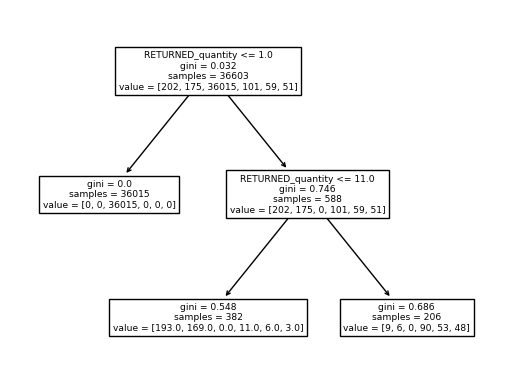

In [55]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(X_train, y_train) # Model trainen
tree.plot_tree(dtree, feature_names=X.columns) # Boomstructuur weergeven
plt.show()

In [72]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURNED_REASON_description'], predicted_df], axis=1)
model_results_frame.to_sql('MODEL_RESULTS', con=sqlite_conn, if_exists='replace', index=False)

model_results_frame

,RETURNED_REASON_description,Predicted_Return_Reason
0,Wrong product shipped,Wrong product shipped
1,Incomplete product,Incomplete product
2,Defective product,Defective product
3,Defective product,Defective product
4,Incomplete product,Incomplete product
...,...,...
101,Incomplete product,Defective product
102,Wrong product ordered,Wrong product ordered
103,Wrong product ordered,Wrong product ordered
104,Defective product,Defective product


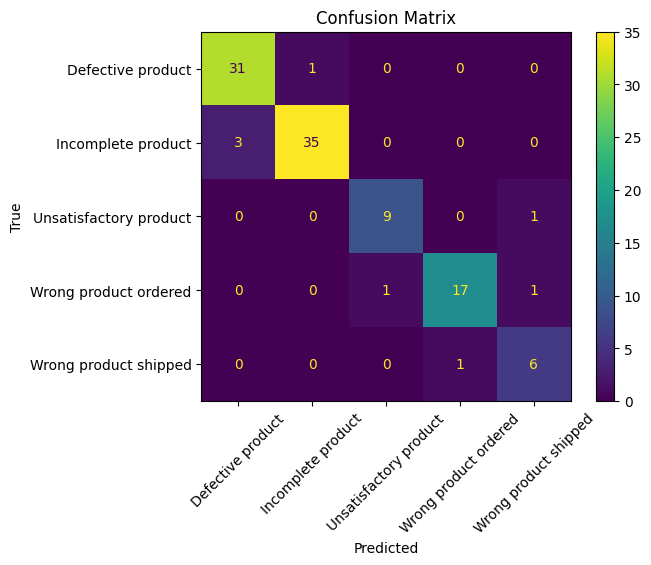

In [74]:
labels = ['Defective product', 'Incomplete product',
       'Unsatisfactory product', 'Wrong product ordered',
       'Wrong product shipped']
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

cm_display.plot()
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [80]:
metrics.accuracy_score(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason']) # Accuracy score berekenen, hoeveel procent van de voorspellingen is correct. 1 is 100% correct, 0 is 0% correct

0.4056603773584906

In [92]:
print(classification_report(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason']) ) # Classification report weergeven

                        precision    recall  f1-score   support

     Defective product       0.45      0.53      0.49        32
    Incomplete product       0.53      0.45      0.49        38
Unsatisfactory product       0.20      0.30      0.24        10
 Wrong product ordered       0.62      0.26      0.37        19
 Wrong product shipped       0.15      0.29      0.20         7

              accuracy                           0.42       106
             macro avg       0.39      0.37      0.36       106
          weighted avg       0.47      0.42      0.42       106



# Max_depth = 3

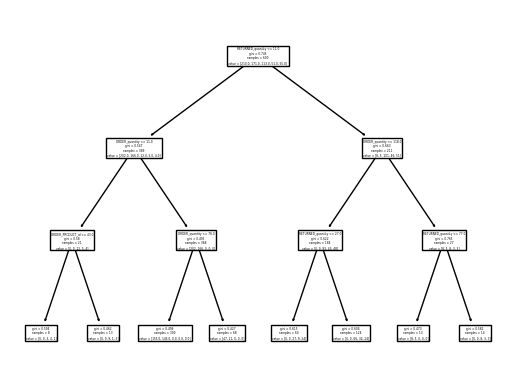

In [75]:
dtree = DecisionTreeClassifier(max_depth=3)
dtree = dtree.fit(X_train, y_train) # Model trainen
tree.plot_tree(dtree, feature_names=X.columns) # Boomstructuur weergeven
plt.show()

In [76]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURNED_REASON_description'], predicted_df], axis=1)
model_results_frame
model_results_frame.to_sql('MODEL_RESULTS', con=sqlite_conn, if_exists='replace', index=False)

106

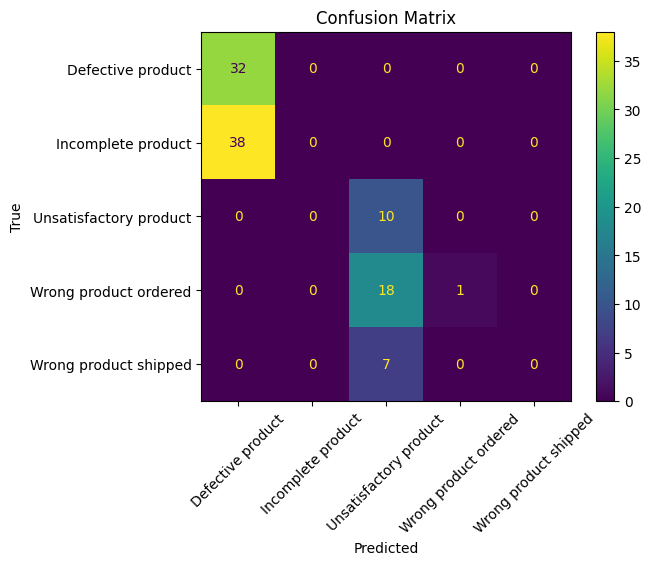

In [78]:
labels = ['Defective product', 'Incomplete product',
       'Unsatisfactory product', 'Wrong product ordered',
       'Wrong product shipped']
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

cm_display.plot()
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [79]:
metrics.accuracy_score(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason']) # Accuracy score berekenen, hoeveel procent van de voorspellingen is correct. 1 is 100% correct, 0 is 0% correct

0.4056603773584906

# Geen Max_depth

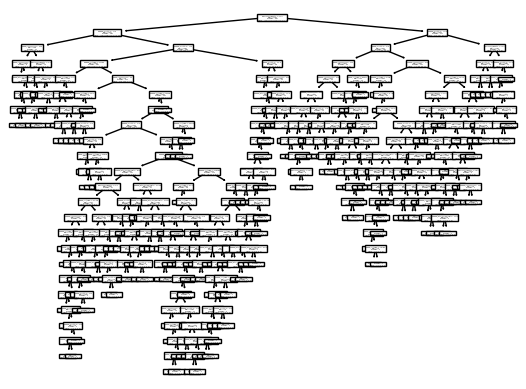

In [83]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train) # Model trainen
tree.plot_tree(dtree, feature_names=X.columns) # Boomstructuur weergeven
plt.show()

In [84]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURNED_REASON_description'], predicted_df], axis=1)
model_results_frame
model_results_frame.to_sql('MODEL_RESULTS', con=sqlite_conn, if_exists='replace', index=False)

106

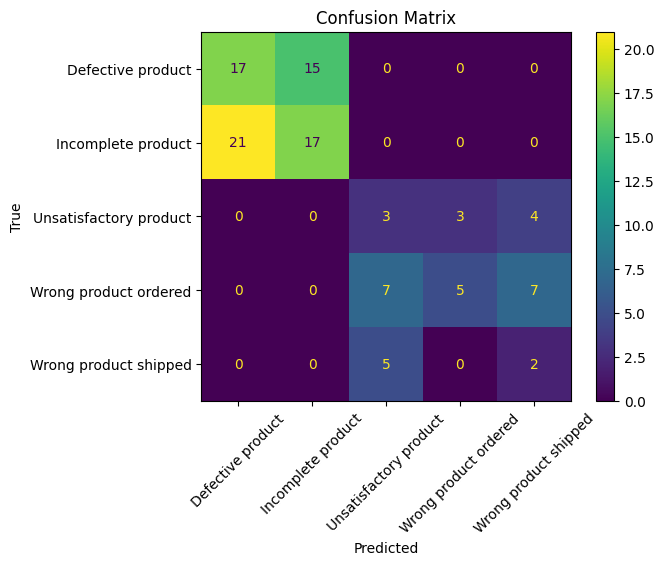

In [85]:
labels = ['Defective product', 'Incomplete product',
       'Unsatisfactory product', 'Wrong product ordered',
       'Wrong product shipped']
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

cm_display.plot()
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [86]:
metrics.accuracy_score(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason']) # Accuracy score berekenen, hoeveel procent van de voorspellingen is correct. 1 is 100% correct, 0 is 0% correct

0.41509433962264153